In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import time
from keras.models import load_model
from MadsNeural_network_500epoch import *

# Flag
WIRE_ANTENNA = True
MIFA_ANTENNA = False

# @keras.saving.register_keras_serializable()
# def weighted_loss(y_true, y_pred):
#     e = y_pred - y_true
#     # Apply different weights based on the input parameters
#     e1 = e[:, :2]*2 # Increase the weight for the first two parameters
#     e2 = e[:, 2:]
#     return K.mean(K.square(K.concatenate([e1, e2], axis=-1)), axis=-1)

@keras.saving.register_keras_serializable()
def weighted_mse_forward(y_true, y_pred):
    #Pass y_true values through a sigmoid function
    weights = 2* K.sigmoid(-y_true)+2

    return K.mean(weights * K.square(y_pred - y_true), axis=-1)

if WIRE_ANTENNA:
    @keras.saving.register_keras_serializable()
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, :2]*5 # Increase the weight for the first two parameters
        e2 = e[:, 2:]
        return K.mean(K.square(K.concatenate([e1, e2], axis=-1)), axis=-1)


if MIFA_ANTENNA:
    @keras.saving.register_keras_serializable()
    def weighted_loss(y_true, y_pred):
        e = y_pred - y_true
        # Apply different weights based on the input parameters
        e1 = e[:, 0]*5
        e2 = e[:, 2]*5# Increase the weight for the first two parameters
        e3 = e[:, 1]
        e4 = e[:, 3]
        
        return K.mean(K.square(K.concatenate([e1, e2, e3, e4], axis=-1)), axis=-1)


VALIDATA_S11_CURVES = False

path = "C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning"
if WIRE_ANTENNA:
    par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency = load_data('data/Wire_Results/simple_wire2_final_with_parametric.pkl')
elif MIFA_ANTENNA:
    par_comb, S11_vals, frequency, degrees, combined_gain, std_dev, efficiency = load_data('data/MIFA_Results/MIFA_results.pkl')


input_vector = par_comb

output_vector = np.asarray([np.concatenate((S11_vals[i], [std_dev[i]], [efficiency[i]]))for i in range(S11_vals.shape[0])])

# Split data into training and testing sets, we need the distribution to normalize like in the forward model
x_train, x_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)

# x_train_norm = normalize_data(x_train, np.mean(x_train),np.std(x_train), False)
# x_test_norm = normalize_data(x_test, np.mean(x_test),np.std(x_test), False)
# y_train_norm = normalize_data(y_train, np.mean(y_train),np.std(y_train), False)
# y_test_norm = normalize_data(y_test, np.mean(y_test),np.std(y_test), False)



Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])


In [10]:
# Load forward model
if WIRE_ANTENNA:
    forward_model = load_model(path + "/data/Wire_Results/Forward_model_wire.keras", custom_objects={'weighted_mse': weighted_mse_forward})
elif MIFA_ANTENNA:
    forward_model = load_model(path + "/data/MIFA_Results/Forward_model_MIFA.keras", custom_objects={'weighted_mse': weighted_mse_forward})
forward_model.summary()

if WIRE_ANTENNA:
    # Generate random data for wire_length, wire_height and wire_radius within the minimum and maximum values
    wire_length =[157/10,157]
    wire_height = [4,15]
    wire_radius = [0.5,3]

    # Generate random data for the wire_length, wire_height and wire_width
    wire_length = np.random.uniform(wire_length[0],wire_length[1],100)
    wire_height = np.random.uniform(wire_height[0],wire_height[1],50)
    wire_radius = np.random.uniform(wire_radius[0],wire_radius[1],20)

    # Combine wire_length, wire_height and wire_width into a list of lists
    param_combination = [[w_l,w_h,w_r] for w_l in wire_length
                         for w_h in wire_height
                         for w_r in wire_radius]

    #Shuffle the columns in the list (does not move items between columns)
    random.seed(42)
    random.shuffle(param_combination)
    
    # Normalize the data, with the same normalization used in the training of the forward model

    param_combination_norm = normalize_data(param_combination, np.mean(x_train),np.std(x_train),False)

if MIFA_ANTENNA:
    Tw1 = [2,8]
    groundingPinTopLength = [3,7]
    Line1_height = [8,16]
    substrateH = [0.7,0.9]
    
    Tw1 = np.random.uniform(Tw1[0],Tw1[1],30)
    groundingPinTopLength = np.random.uniform(groundingPinTopLength[0],groundingPinTopLength[1],30)
    Line1_height = np.random.uniform(Line1_height[0],Line1_height[1],20)
    substrateH = np.random.uniform(substrateH[0],substrateH[1],10)
    
    param_combination = [[Tw1_val,groundingPinTopLength_val,Line1_height_val,substrateH_val] for Tw1_val in Tw1 
                         for groundingPinTopLength_val in groundingPinTopLength 
                         for Line1_height_val in Line1_height 
                         for substrateH_val in substrateH]
    random.seed(42)
    random.shuffle(param_combination)
    # Normalize the data, with the same normalization used in the training of the forward model
    param_combination_norm = normalize_data(param_combination, np.mean(x_train),np.std(x_train),False)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               6

In [11]:

# Feed the param combinations to the forward model
forward_model_predictions_norm = forward_model.predict(param_combination_norm)

#Reverse the normalization
forward_model_predictions = normalize_data(forward_model_predictions_norm, np.mean(y_train), np.std(y_train), True)

#Keep only the S11 values
forward_model_predictions = forward_model_predictions[:,:1001]

data_dictionary = {'Parameter combination': param_combination, 'S1,1': forward_model_predictions, 'Frequency': frequency}

if WIRE_ANTENNA:
    with open('data/Wire_Results/Wire_interpolated_data.pkl', 'wb') as f:
        pickle.dump(data_dictionary, f)
elif MIFA_ANTENNA:
    with open('data/MIFA_Results/MIFA_interpolated_data.pkl', 'wb') as f:
        pickle.dump(data_dictionary, f)

# Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
good_indices = []
for idx, i in enumerate(forward_model_predictions):
    if np.min(i) < -10 and frequency[np.argmin(i)] in range(1800,2000):
        good_indices.append(idx)
print(f"Found {len(good_indices)} s11 curves that fulfill the criteria")

good_s11_curves = []
for i in good_indices:
    good_s11_curves.append(list(forward_model_predictions[i]))
    
good_s11_curves = np.asarray(good_s11_curves)

3125/3125 [==============================] - 5s 2ms/step
Found 2758 s11 curves that fulfill the criteria


In [12]:
if VALIDATA_S11_CURVES:
    # Plot the forward model predictions
    random_indices = random.sample(range(0, len(good_indices)), 10)
    for i in random_indices:
        plt.plot(frequency, forward_model_predictions[i])
    plt.show()


In [13]:

# Load the inverse model
if WIRE_ANTENNA:
    inverse_model = load_model("data/Wire_Results/wire_inverse_model_1.keras", custom_objects={'weighted_mse': weighted_loss})
if MIFA_ANTENNA:
    inverse_model = load_model("data/MIFA_Results/MIFA_inverse_model_1.keras", custom_objects={'weighted_mse': weighted_loss})
inverse_model.summary()

# Feed the forward model predictions to the inverse model
inverse_model_predictions_norm = inverse_model.predict(good_s11_curves)

inverse_model_predictions = normalize_data(inverse_model_predictions_norm, np.mean(par_comb), np.std(par_comb), True)

random_par_preds = random.sample(list(inverse_model_predictions), 10)
[print(i) for i in random_par_preds]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               256512    
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 layer5 (Dense)              (None, 256)               65792     
                                                                 
 layer6 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 3)                 7

[None, None, None, None, None, None, None, None, None, None]

1/1 [==============================] - 0s 18ms/step
Predicted parameters: [129.21861    10.934671    2.9163532]
Real parameters: [113.74538059609509, 13.094076184411714, 1.580139317922143]


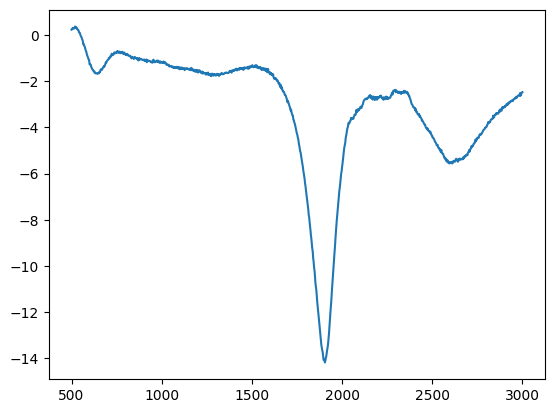

In [14]:
test_index = np.random.randint(0, len(good_indices))

# Print the predicted and real parameters for a test curve
print(f'Predicted parameters: {normalize_data(inverse_model.predict(np.array([good_s11_curves[test_index]])), np.mean(par_comb), np.std(par_comb), True)[0]}')
print(f'Real parameters: {param_combination[good_indices[test_index]]}')

# Plot the target s11 curve
plt.plot(frequency, good_s11_curves[test_index])
plt.show()

#[159.49065    11.178757    2.4185696]

In [15]:
# with open('data\MIFA_results\MIFA_real_cst_BW_center.pkl', 'rb') as f:
#     MIFA_real = pickle.load(f)
# with open('data\MIFA_results\MIFA_results_with_band_centre', 'rb') as f:
#     MIFA_extrapolated = pickle.load(f)

# good_real = []
# [good_real.append([MIFA_real['bandwidth'][idx], MIFA_real['centre_frequency'][idx]]) for idx, i in enumerate(MIFA_real['bandwidth']) if i > 10 and MIFA_real['centre_frequency'][idx] < 2000]

# good_extrapolate = []
# [good_extrapolate.append([MIFA_extrapolated['bandwidth'][idx],MIFA_extrapolated['centre_frequency'][idx]]) for idx, i in enumerate(MIFA_extrapolated['bandwidth']) if i > 10 and MIFA_extrapolated['centre_frequency'][idx] < 2000]

# print(good_real)
# print(good_extrapolate)